# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


In [2]:
print(device)

cuda:0


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [3]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [4]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [5]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [23]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(z_dim, h_dim_1)
    self.fc2 = nn.Linear(h_dim_1, h_dim_2)
    self.fc3 = nn.Linear(h_dim_2, self.n_pixels)
  def forward(self, z):
    y = torch.tanh(self.fc3(F.leaky_relu(self.fc2(F.leaky_relu(self.fc1(z), 0.2)), 0.2))).view(-1,1,28,28)

    return(y)


In [24]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = torch.sigmoid(self.fc3(F.leaky_relu(self.fc2(F.leaky_relu(self.fc1(x.view(-1,n_pixels)), 0.2)), 0.2)))
    return y




Create generator and discriminator 

In [8]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows, n_cols, n_channels)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [9]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))
  return loss_gen


### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [10]:
def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Device: cuda:0
Starting Training
[0/400][0/16]	Loss_D: 1.4494	Loss_G: -0.6668	D(x): 0.4576	D(G(z)): 0.4870


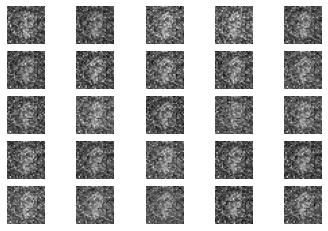

[1/400][0/16]	Loss_D: 0.9783	Loss_G: -0.7630	D(x): 0.8625	D(G(z)): 0.5636
[2/400][0/16]	Loss_D: 1.1924	Loss_G: -0.7422	D(x): 0.7546	D(G(z)): 0.5967
[3/400][0/16]	Loss_D: 1.1773	Loss_G: -0.6290	D(x): 0.6810	D(G(z)): 0.5459
[4/400][0/16]	Loss_D: 1.5114	Loss_G: -0.7992	D(x): 0.6362	D(G(z)): 0.6515
[5/400][0/16]	Loss_D: 1.2232	Loss_G: -0.7031	D(x): 0.4481	D(G(z)): 0.3268
[6/400][0/16]	Loss_D: 0.4967	Loss_G: -0.2072	D(x): 0.8327	D(G(z)): 0.2685
[7/400][0/16]	Loss_D: 1.5430	Loss_G: -0.2794	D(x): 0.8941	D(G(z)): 0.7422
[8/400][0/16]	Loss_D: 0.3100	Loss_G: -0.1368	D(x): 0.8945	D(G(z)): 0.1791
[9/400][0/16]	Loss_D: 0.2397	Loss_G: -0.0755	D(x): 0.9656	D(G(z)): 0.1787
[10/400][0/16]	Loss_D: 0.6380	Loss_G: -0.2806	D(x): 0.7747	D(G(z)): 0.3163
[11/400][0/16]	Loss_D: 1.0955	Loss_G: -0.5149	D(x): 0.7910	D(G(z)): 0.5057
[12/400][0/16]	Loss_D: 1.2532	Loss_G: -0.5954	D(x): 0.6484	D(G(z)): 0.5531
[13/400][0/16]	Loss_D: 0.9990	Loss_G: -0.3957	D(x): 0.6697	D(G(z)): 0.4469
[14/400][0/16]	Loss_D: 1.1431	Loss

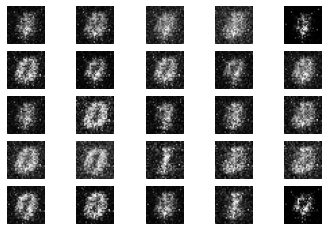

[26/400][0/16]	Loss_D: 0.9947	Loss_G: -0.6201	D(x): 0.5315	D(G(z)): 0.2174
[27/400][0/16]	Loss_D: 1.0491	Loss_G: -0.6366	D(x): 0.5040	D(G(z)): 0.2287
[28/400][0/16]	Loss_D: 1.2214	Loss_G: -0.6070	D(x): 0.5236	D(G(z)): 0.3619
[29/400][0/16]	Loss_D: 1.3582	Loss_G: -0.3543	D(x): 0.6313	D(G(z)): 0.5687
[30/400][0/16]	Loss_D: 0.8468	Loss_G: -0.2818	D(x): 0.7888	D(G(z)): 0.4465
[31/400][0/16]	Loss_D: 1.5621	Loss_G: -0.2263	D(x): 0.8820	D(G(z)): 0.7393
[32/400][0/16]	Loss_D: 0.5964	Loss_G: -0.2328	D(x): 0.7694	D(G(z)): 0.2678
[33/400][0/16]	Loss_D: 1.1248	Loss_G: -0.0904	D(x): 0.7635	D(G(z)): 0.5551
[34/400][0/16]	Loss_D: 0.7004	Loss_G: -0.2374	D(x): 0.8221	D(G(z)): 0.3802
[35/400][0/16]	Loss_D: 0.9601	Loss_G: -0.3044	D(x): 0.6762	D(G(z)): 0.3919
[36/400][0/16]	Loss_D: 0.7088	Loss_G: -0.0968	D(x): 0.8328	D(G(z)): 0.3865
[37/400][0/16]	Loss_D: 1.0657	Loss_G: -0.3301	D(x): 0.4655	D(G(z)): 0.1295
[38/400][0/16]	Loss_D: 0.5171	Loss_G: -0.1653	D(x): 0.8713	D(G(z)): 0.2996
[39/400][0/16]	Loss_D: 1.

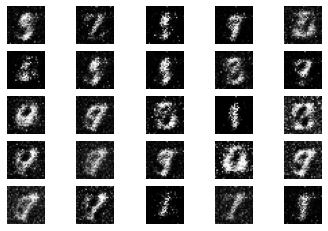

[51/400][0/16]	Loss_D: 0.9535	Loss_G: -0.5050	D(x): 0.5363	D(G(z)): 0.2146
[52/400][0/16]	Loss_D: 0.8749	Loss_G: -0.1813	D(x): 0.7195	D(G(z)): 0.3874
[53/400][0/16]	Loss_D: 0.8450	Loss_G: -0.2164	D(x): 0.6462	D(G(z)): 0.2913
[54/400][0/16]	Loss_D: 1.1819	Loss_G: -0.1000	D(x): 0.9039	D(G(z)): 0.6116
[55/400][0/16]	Loss_D: 0.9623	Loss_G: -0.2812	D(x): 0.6980	D(G(z)): 0.4316
[56/400][0/16]	Loss_D: 0.9719	Loss_G: -0.4568	D(x): 0.6112	D(G(z)): 0.3136
[57/400][0/16]	Loss_D: 0.7720	Loss_G: -0.2053	D(x): 0.7529	D(G(z)): 0.3529
[58/400][0/16]	Loss_D: 1.0434	Loss_G: -0.2697	D(x): 0.7285	D(G(z)): 0.4845
[59/400][0/16]	Loss_D: 0.8955	Loss_G: -0.3171	D(x): 0.7146	D(G(z)): 0.3916
[60/400][0/16]	Loss_D: 0.7365	Loss_G: -0.2235	D(x): 0.7314	D(G(z)): 0.3197
[61/400][0/16]	Loss_D: 1.3249	Loss_G: -0.1542	D(x): 0.9145	D(G(z)): 0.6663
[62/400][0/16]	Loss_D: 0.8447	Loss_G: -0.2739	D(x): 0.5784	D(G(z)): 0.1989
[63/400][0/16]	Loss_D: 0.9684	Loss_G: -0.4754	D(x): 0.4715	D(G(z)): 0.1383
[64/400][0/16]	Loss_D: 0.

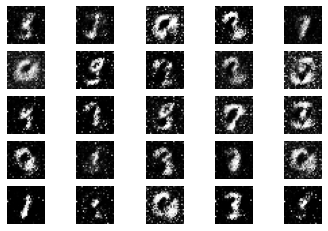

[76/400][0/16]	Loss_D: 0.7389	Loss_G: -0.2048	D(x): 0.6008	D(G(z)): 0.0759
[77/400][0/16]	Loss_D: 0.8011	Loss_G: -0.1373	D(x): 0.8412	D(G(z)): 0.3343
[78/400][0/16]	Loss_D: 0.3983	Loss_G: -0.1916	D(x): 0.8299	D(G(z)): 0.1525
[79/400][0/16]	Loss_D: 0.7497	Loss_G: -0.2073	D(x): 0.8787	D(G(z)): 0.4369
[80/400][0/16]	Loss_D: 0.9025	Loss_G: -0.4215	D(x): 0.5041	D(G(z)): 0.0667
[81/400][0/16]	Loss_D: 0.5937	Loss_G: -0.3565	D(x): 0.7101	D(G(z)): 0.1687
[82/400][0/16]	Loss_D: 0.8741	Loss_G: -0.5316	D(x): 0.6389	D(G(z)): 0.2366
[83/400][0/16]	Loss_D: 0.6468	Loss_G: -0.2469	D(x): 0.6617	D(G(z)): 0.1439
[84/400][0/16]	Loss_D: 0.8188	Loss_G: -0.1087	D(x): 0.8420	D(G(z)): 0.4299
[85/400][0/16]	Loss_D: 0.6250	Loss_G: -0.3188	D(x): 0.6552	D(G(z)): 0.0563
[86/400][0/16]	Loss_D: 1.1555	Loss_G: -0.7822	D(x): 0.4273	D(G(z)): 0.1005
[87/400][0/16]	Loss_D: 0.6350	Loss_G: -0.0335	D(x): 0.9242	D(G(z)): 0.4060
[88/400][0/16]	Loss_D: 0.2763	Loss_G: -0.1233	D(x): 0.9009	D(G(z)): 0.1449
[89/400][0/16]	Loss_D: 1.

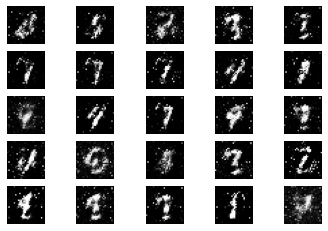

[101/400][0/16]	Loss_D: 0.5530	Loss_G: -0.1303	D(x): 0.8261	D(G(z)): 0.2564
[102/400][0/16]	Loss_D: 0.8169	Loss_G: -0.0435	D(x): 0.9291	D(G(z)): 0.4863
[103/400][0/16]	Loss_D: 0.4788	Loss_G: -0.3191	D(x): 0.7619	D(G(z)): 0.1452
[104/400][0/16]	Loss_D: 0.3731	Loss_G: -0.1236	D(x): 0.8669	D(G(z)): 0.1764
[105/400][0/16]	Loss_D: 0.3631	Loss_G: -0.1248	D(x): 0.8827	D(G(z)): 0.1869
[106/400][0/16]	Loss_D: 0.6081	Loss_G: -0.6037	D(x): 0.7121	D(G(z)): 0.1347
[107/400][0/16]	Loss_D: 2.5396	Loss_G: -0.0084	D(x): 0.9866	D(G(z)): 0.8968
[108/400][0/16]	Loss_D: 0.6182	Loss_G: -0.1426	D(x): 0.8362	D(G(z)): 0.3196
[109/400][0/16]	Loss_D: 0.4016	Loss_G: -0.2044	D(x): 0.8225	D(G(z)): 0.1236
[110/400][0/16]	Loss_D: 0.4948	Loss_G: -0.1520	D(x): 0.9036	D(G(z)): 0.2664
[111/400][0/16]	Loss_D: 0.7864	Loss_G: -0.1073	D(x): 0.8348	D(G(z)): 0.3550
[112/400][0/16]	Loss_D: 0.8665	Loss_G: -0.4594	D(x): 0.5729	D(G(z)): 0.0930
[113/400][0/16]	Loss_D: 0.2707	Loss_G: -0.1007	D(x): 0.8925	D(G(z)): 0.1283
[114/400][0/

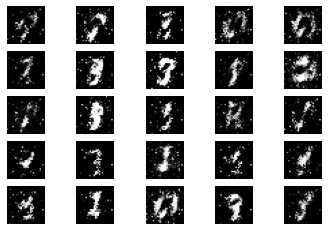

[126/400][0/16]	Loss_D: 1.0096	Loss_G: -0.4884	D(x): 0.4863	D(G(z)): 0.0509
[127/400][0/16]	Loss_D: 0.7542	Loss_G: -0.0320	D(x): 0.9320	D(G(z)): 0.4560
[128/400][0/16]	Loss_D: 0.4993	Loss_G: -0.1884	D(x): 0.7975	D(G(z)): 0.2112
[129/400][0/16]	Loss_D: 0.5795	Loss_G: -0.0830	D(x): 0.6990	D(G(z)): 0.1519
[130/400][0/16]	Loss_D: 0.7904	Loss_G: -0.5089	D(x): 0.6681	D(G(z)): 0.1748
[131/400][0/16]	Loss_D: 1.2887	Loss_G: -0.6140	D(x): 0.3701	D(G(z)): 0.0841
[132/400][0/16]	Loss_D: 0.7753	Loss_G: -0.2846	D(x): 0.6922	D(G(z)): 0.2750
[133/400][0/16]	Loss_D: 0.7255	Loss_G: -0.1073	D(x): 0.7952	D(G(z)): 0.2608
[134/400][0/16]	Loss_D: 0.7764	Loss_G: -0.0951	D(x): 0.8552	D(G(z)): 0.4055
[135/400][0/16]	Loss_D: 0.7015	Loss_G: -0.0773	D(x): 0.9018	D(G(z)): 0.4056
[136/400][0/16]	Loss_D: 1.0811	Loss_G: -0.0732	D(x): 0.8556	D(G(z)): 0.5579
[137/400][0/16]	Loss_D: 0.8261	Loss_G: -0.0450	D(x): 0.9629	D(G(z)): 0.5094
[138/400][0/16]	Loss_D: 0.6891	Loss_G: -0.5995	D(x): 0.6216	D(G(z)): 0.1351
[139/400][0/

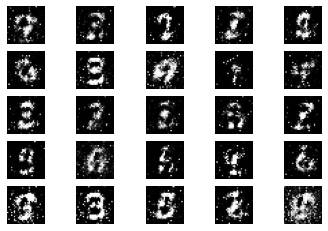

[151/400][0/16]	Loss_D: 0.3076	Loss_G: -0.1799	D(x): 0.8526	D(G(z)): 0.0975
[152/400][0/16]	Loss_D: 0.2175	Loss_G: -0.0797	D(x): 0.8645	D(G(z)): 0.0503
[153/400][0/16]	Loss_D: 0.3606	Loss_G: -0.1326	D(x): 0.8451	D(G(z)): 0.1389
[154/400][0/16]	Loss_D: 0.4722	Loss_G: -0.0589	D(x): 0.8094	D(G(z)): 0.1718
[155/400][0/16]	Loss_D: 0.3748	Loss_G: -0.1182	D(x): 0.8731	D(G(z)): 0.1693
[156/400][0/16]	Loss_D: 0.6479	Loss_G: -0.0938	D(x): 0.7819	D(G(z)): 0.2609
[157/400][0/16]	Loss_D: 0.5165	Loss_G: -0.4124	D(x): 0.7211	D(G(z)): 0.1013
[158/400][0/16]	Loss_D: 0.5353	Loss_G: -0.0372	D(x): 0.9492	D(G(z)): 0.3447
[159/400][0/16]	Loss_D: 1.1943	Loss_G: -1.0137	D(x): 0.4502	D(G(z)): 0.0212
[160/400][0/16]	Loss_D: 0.8575	Loss_G: -0.4006	D(x): 0.5395	D(G(z)): 0.0387
[161/400][0/16]	Loss_D: 0.4199	Loss_G: -0.1803	D(x): 0.7501	D(G(z)): 0.0383
[162/400][0/16]	Loss_D: 0.7548	Loss_G: -0.1927	D(x): 0.5588	D(G(z)): 0.0500
[163/400][0/16]	Loss_D: 0.4627	Loss_G: -0.0841	D(x): 0.7232	D(G(z)): 0.0477
[164/400][0/

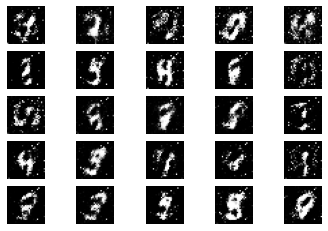

[176/400][0/16]	Loss_D: 0.5602	Loss_G: -0.1616	D(x): 0.9134	D(G(z)): 0.2971
[177/400][0/16]	Loss_D: 0.6765	Loss_G: -0.7490	D(x): 0.7267	D(G(z)): 0.1400
[178/400][0/16]	Loss_D: 0.4617	Loss_G: -0.2772	D(x): 0.7717	D(G(z)): 0.0641
[179/400][0/16]	Loss_D: 1.8274	Loss_G: -0.0146	D(x): 0.9309	D(G(z)): 0.7560
[180/400][0/16]	Loss_D: 0.5216	Loss_G: -0.2538	D(x): 0.8353	D(G(z)): 0.2264
[181/400][0/16]	Loss_D: 1.0125	Loss_G: -0.2760	D(x): 0.5403	D(G(z)): 0.0591
[182/400][0/16]	Loss_D: 0.7577	Loss_G: -0.0269	D(x): 0.9285	D(G(z)): 0.4655
[183/400][0/16]	Loss_D: 0.9926	Loss_G: -0.2659	D(x): 0.5717	D(G(z)): 0.0705
[184/400][0/16]	Loss_D: 0.7402	Loss_G: -0.3220	D(x): 0.6346	D(G(z)): 0.0817
[185/400][0/16]	Loss_D: 0.6582	Loss_G: -0.1898	D(x): 0.7522	D(G(z)): 0.1459
[186/400][0/16]	Loss_D: 1.1649	Loss_G: -0.0348	D(x): 0.9661	D(G(z)): 0.6011
[187/400][0/16]	Loss_D: 0.9984	Loss_G: -0.3525	D(x): 0.5532	D(G(z)): 0.1305
[188/400][0/16]	Loss_D: 0.4202	Loss_G: -0.0599	D(x): 0.9318	D(G(z)): 0.2742
[189/400][0/

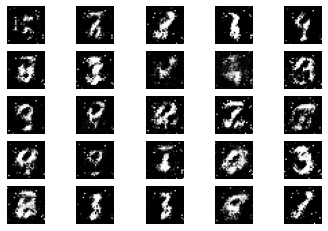

[201/400][0/16]	Loss_D: 1.8299	Loss_G: -0.0238	D(x): 0.9883	D(G(z)): 0.7061
[202/400][0/16]	Loss_D: 0.3353	Loss_G: -0.1186	D(x): 0.8794	D(G(z)): 0.1717
[203/400][0/16]	Loss_D: 0.6296	Loss_G: -0.1461	D(x): 0.8063	D(G(z)): 0.2701
[204/400][0/16]	Loss_D: 0.7597	Loss_G: -0.5553	D(x): 0.5998	D(G(z)): 0.0840
[205/400][0/16]	Loss_D: 0.5681	Loss_G: -0.1278	D(x): 0.7787	D(G(z)): 0.1982
[206/400][0/16]	Loss_D: 0.2528	Loss_G: -0.0945	D(x): 0.8607	D(G(z)): 0.0815
[207/400][0/16]	Loss_D: 0.5943	Loss_G: -0.1797	D(x): 0.6917	D(G(z)): 0.0531
[208/400][0/16]	Loss_D: 0.4296	Loss_G: -0.2934	D(x): 0.7778	D(G(z)): 0.1275
[209/400][0/16]	Loss_D: 0.8315	Loss_G: -0.0178	D(x): 0.9552	D(G(z)): 0.4693
[210/400][0/16]	Loss_D: 0.3578	Loss_G: -0.2091	D(x): 0.8123	D(G(z)): 0.0849
[211/400][0/16]	Loss_D: 0.3295	Loss_G: -0.1288	D(x): 0.8342	D(G(z)): 0.1040
[212/400][0/16]	Loss_D: 0.4416	Loss_G: -0.1139	D(x): 0.8022	D(G(z)): 0.0703
[213/400][0/16]	Loss_D: 0.7045	Loss_G: -0.0299	D(x): 0.9539	D(G(z)): 0.4000
[214/400][0/

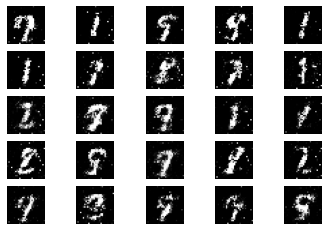

[226/400][0/16]	Loss_D: 0.4837	Loss_G: -0.1033	D(x): 0.8859	D(G(z)): 0.2613
[227/400][0/16]	Loss_D: 0.2995	Loss_G: -0.0886	D(x): 0.9062	D(G(z)): 0.1285
[228/400][0/16]	Loss_D: 0.6301	Loss_G: -0.2561	D(x): 0.8083	D(G(z)): 0.2585
[229/400][0/16]	Loss_D: 0.3007	Loss_G: -0.0398	D(x): 0.9119	D(G(z)): 0.1662
[230/400][0/16]	Loss_D: 0.3197	Loss_G: -0.1540	D(x): 0.8788	D(G(z)): 0.1471
[231/400][0/16]	Loss_D: 0.6822	Loss_G: -0.2548	D(x): 0.6284	D(G(z)): 0.0382
[232/400][0/16]	Loss_D: 0.4015	Loss_G: -0.2031	D(x): 0.8203	D(G(z)): 0.1060
[233/400][0/16]	Loss_D: 1.2681	Loss_G: -0.0063	D(x): 0.9456	D(G(z)): 0.4976
[234/400][0/16]	Loss_D: 0.6276	Loss_G: -0.4610	D(x): 0.6575	D(G(z)): 0.0937
[235/400][0/16]	Loss_D: 0.4087	Loss_G: -0.0554	D(x): 0.9304	D(G(z)): 0.2560
[236/400][0/16]	Loss_D: 0.5179	Loss_G: -0.3145	D(x): 0.7231	D(G(z)): 0.1111
[237/400][0/16]	Loss_D: 0.5993	Loss_G: -0.0158	D(x): 0.9402	D(G(z)): 0.3704
[238/400][0/16]	Loss_D: 0.5598	Loss_G: -0.0428	D(x): 0.9547	D(G(z)): 0.3522
[239/400][0/

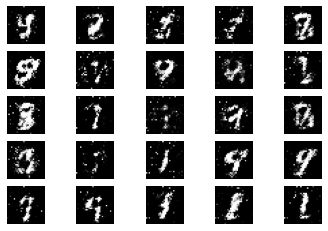

[251/400][0/16]	Loss_D: 1.5173	Loss_G: -0.4734	D(x): 0.3991	D(G(z)): 0.0311
[252/400][0/16]	Loss_D: 0.3303	Loss_G: -0.2001	D(x): 0.8883	D(G(z)): 0.1472
[253/400][0/16]	Loss_D: 0.5083	Loss_G: -0.2543	D(x): 0.7092	D(G(z)): 0.0601
[254/400][0/16]	Loss_D: 0.8090	Loss_G: -0.0628	D(x): 0.8510	D(G(z)): 0.4157
[255/400][0/16]	Loss_D: 0.2987	Loss_G: -0.0506	D(x): 0.9552	D(G(z)): 0.2098
[256/400][0/16]	Loss_D: 0.6772	Loss_G: -0.0368	D(x): 0.9786	D(G(z)): 0.4093
[257/400][0/16]	Loss_D: 1.2040	Loss_G: -0.0022	D(x): 0.9780	D(G(z)): 0.6115
[258/400][0/16]	Loss_D: 0.3731	Loss_G: -0.0941	D(x): 0.8307	D(G(z)): 0.0954
[259/400][0/16]	Loss_D: 0.3072	Loss_G: -0.1009	D(x): 0.8727	D(G(z)): 0.1198
[260/400][0/16]	Loss_D: 1.1614	Loss_G: -0.0066	D(x): 0.9755	D(G(z)): 0.5937
[261/400][0/16]	Loss_D: 0.5774	Loss_G: -0.1720	D(x): 0.7190	D(G(z)): 0.0752
[262/400][0/16]	Loss_D: 0.3099	Loss_G: -0.0484	D(x): 0.8486	D(G(z)): 0.0705
[263/400][0/16]	Loss_D: 0.4059	Loss_G: -0.0159	D(x): 0.9664	D(G(z)): 0.2858
[264/400][0/

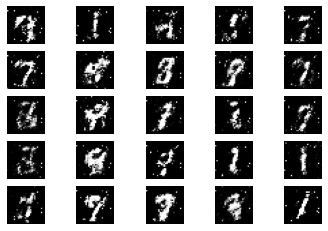

[276/400][0/16]	Loss_D: 0.3291	Loss_G: -0.1323	D(x): 0.8634	D(G(z)): 0.1404
[277/400][0/16]	Loss_D: 0.3610	Loss_G: -0.1486	D(x): 0.8782	D(G(z)): 0.1757
[278/400][0/16]	Loss_D: 0.5084	Loss_G: -0.1075	D(x): 0.7399	D(G(z)): 0.0588
[279/400][0/16]	Loss_D: 0.6872	Loss_G: -0.2310	D(x): 0.7195	D(G(z)): 0.1202
[280/400][0/16]	Loss_D: 0.4092	Loss_G: -0.1304	D(x): 0.9065	D(G(z)): 0.2104
[281/400][0/16]	Loss_D: 0.6197	Loss_G: -0.1526	D(x): 0.8586	D(G(z)): 0.2803
[282/400][0/16]	Loss_D: 0.4853	Loss_G: -0.5075	D(x): 0.7775	D(G(z)): 0.1203
[283/400][0/16]	Loss_D: 0.6229	Loss_G: -0.3222	D(x): 0.7412	D(G(z)): 0.1758
[284/400][0/16]	Loss_D: 0.6436	Loss_G: -0.0204	D(x): 0.9533	D(G(z)): 0.4217
[285/400][0/16]	Loss_D: 0.4840	Loss_G: -0.1326	D(x): 0.8256	D(G(z)): 0.1653
[286/400][0/16]	Loss_D: 0.7013	Loss_G: -0.0336	D(x): 0.9436	D(G(z)): 0.4465
[287/400][0/16]	Loss_D: 0.3562	Loss_G: -0.1381	D(x): 0.9299	D(G(z)): 0.2027
[288/400][0/16]	Loss_D: 0.3264	Loss_G: -0.0982	D(x): 0.8143	D(G(z)): 0.0312
[289/400][0/

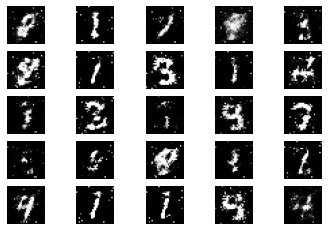

[301/400][0/16]	Loss_D: 0.2981	Loss_G: -0.0384	D(x): 0.8103	D(G(z)): 0.0255
[302/400][0/16]	Loss_D: 0.3878	Loss_G: -0.0967	D(x): 0.8742	D(G(z)): 0.1622
[303/400][0/16]	Loss_D: 0.4960	Loss_G: -0.2213	D(x): 0.8600	D(G(z)): 0.2065
[304/400][0/16]	Loss_D: 0.6360	Loss_G: -0.2544	D(x): 0.7015	D(G(z)): 0.0505
[305/400][0/16]	Loss_D: 0.5067	Loss_G: -0.0911	D(x): 0.7804	D(G(z)): 0.0859
[306/400][0/16]	Loss_D: 0.1930	Loss_G: -0.0985	D(x): 0.9406	D(G(z)): 0.1150
[307/400][0/16]	Loss_D: 1.1476	Loss_G: -0.0029	D(x): 0.9429	D(G(z)): 0.5424
[308/400][0/16]	Loss_D: 0.6591	Loss_G: -0.0071	D(x): 0.9664	D(G(z)): 0.4304
[309/400][0/16]	Loss_D: 0.3053	Loss_G: -0.0450	D(x): 0.9617	D(G(z)): 0.2093
[310/400][0/16]	Loss_D: 0.6857	Loss_G: -0.1403	D(x): 0.9221	D(G(z)): 0.3918
[311/400][0/16]	Loss_D: 0.5190	Loss_G: -0.0853	D(x): 0.7633	D(G(z)): 0.0343
[312/400][0/16]	Loss_D: 0.3086	Loss_G: -0.0556	D(x): 0.8968	D(G(z)): 0.1490
[313/400][0/16]	Loss_D: 1.5593	Loss_G: -0.0081	D(x): 0.9915	D(G(z)): 0.6920
[314/400][0/

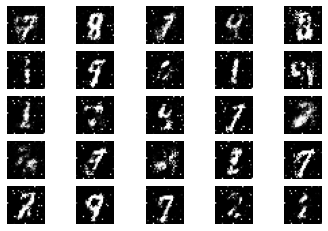

[326/400][0/16]	Loss_D: 0.2578	Loss_G: -0.0714	D(x): 0.9000	D(G(z)): 0.1228
[327/400][0/16]	Loss_D: 1.8847	Loss_G: -0.0061	D(x): 0.9765	D(G(z)): 0.7303
[328/400][0/16]	Loss_D: 0.4438	Loss_G: -0.1066	D(x): 0.7728	D(G(z)): 0.0977
[329/400][0/16]	Loss_D: 0.3428	Loss_G: -0.0734	D(x): 0.9179	D(G(z)): 0.1976
[330/400][0/16]	Loss_D: 0.3342	Loss_G: -0.0819	D(x): 0.8723	D(G(z)): 0.1405
[331/400][0/16]	Loss_D: 0.3402	Loss_G: -0.0508	D(x): 0.9214	D(G(z)): 0.1603
[332/400][0/16]	Loss_D: 1.8738	Loss_G: -0.0008	D(x): 0.9903	D(G(z)): 0.7310
[333/400][0/16]	Loss_D: 1.5852	Loss_G: -0.0135	D(x): 0.9700	D(G(z)): 0.7365
[334/400][0/16]	Loss_D: 0.4167	Loss_G: -0.0782	D(x): 0.7586	D(G(z)): 0.0343
[335/400][0/16]	Loss_D: 0.4649	Loss_G: -0.1216	D(x): 0.8543	D(G(z)): 0.1526
[336/400][0/16]	Loss_D: 0.2559	Loss_G: -0.0923	D(x): 0.9391	D(G(z)): 0.1617
[337/400][0/16]	Loss_D: 0.4793	Loss_G: -0.0105	D(x): 0.9367	D(G(z)): 0.2923
[338/400][0/16]	Loss_D: 1.0772	Loss_G: -0.0188	D(x): 0.9568	D(G(z)): 0.4501
[339/400][0/

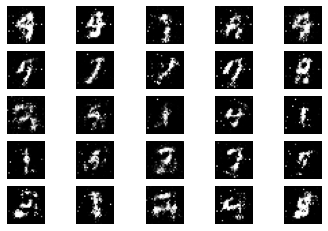

[351/400][0/16]	Loss_D: 1.1423	Loss_G: -0.3980	D(x): 0.4909	D(G(z)): 0.0450
[352/400][0/16]	Loss_D: 0.4180	Loss_G: -0.3117	D(x): 0.8264	D(G(z)): 0.1513
[353/400][0/16]	Loss_D: 0.3806	Loss_G: -0.1346	D(x): 0.8827	D(G(z)): 0.1961
[354/400][0/16]	Loss_D: 0.4679	Loss_G: -0.1354	D(x): 0.8103	D(G(z)): 0.1897
[355/400][0/16]	Loss_D: 0.7921	Loss_G: -0.0233	D(x): 0.9792	D(G(z)): 0.4737
[356/400][0/16]	Loss_D: 0.7414	Loss_G: -0.0087	D(x): 0.9792	D(G(z)): 0.4501
[357/400][0/16]	Loss_D: 1.5568	Loss_G: -0.3593	D(x): 0.4931	D(G(z)): 0.0130
[358/400][0/16]	Loss_D: 0.4614	Loss_G: -0.0924	D(x): 0.8908	D(G(z)): 0.1976
[359/400][0/16]	Loss_D: 0.3173	Loss_G: -0.2673	D(x): 0.8766	D(G(z)): 0.1352
[360/400][0/16]	Loss_D: 0.4392	Loss_G: -0.0977	D(x): 0.8491	D(G(z)): 0.1882
[361/400][0/16]	Loss_D: 0.3995	Loss_G: -0.1378	D(x): 0.8990	D(G(z)): 0.2017
[362/400][0/16]	Loss_D: 0.4446	Loss_G: -0.1368	D(x): 0.8171	D(G(z)): 0.1255
[363/400][0/16]	Loss_D: 0.5235	Loss_G: -0.0661	D(x): 0.9109	D(G(z)): 0.2873
[364/400][0/

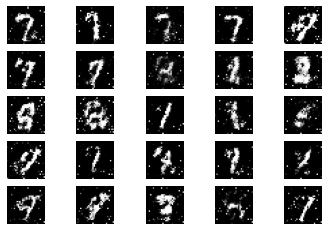

[376/400][0/16]	Loss_D: 0.6350	Loss_G: -0.1791	D(x): 0.7738	D(G(z)): 0.2232
[377/400][0/16]	Loss_D: 0.6100	Loss_G: -0.2878	D(x): 0.6656	D(G(z)): 0.0412
[378/400][0/16]	Loss_D: 0.2918	Loss_G: -0.0545	D(x): 0.8248	D(G(z)): 0.0266
[379/400][0/16]	Loss_D: 0.3455	Loss_G: -0.0921	D(x): 0.8810	D(G(z)): 0.1634
[380/400][0/16]	Loss_D: 1.8370	Loss_G: -0.8584	D(x): 0.3752	D(G(z)): 0.0088
[381/400][0/16]	Loss_D: 0.4471	Loss_G: -0.0961	D(x): 0.8728	D(G(z)): 0.2102
[382/400][0/16]	Loss_D: 0.6047	Loss_G: -0.2260	D(x): 0.6540	D(G(z)): 0.0424
[383/400][0/16]	Loss_D: 0.3382	Loss_G: -0.0779	D(x): 0.8847	D(G(z)): 0.1660
[384/400][0/16]	Loss_D: 1.3148	Loss_G: -0.0182	D(x): 0.9706	D(G(z)): 0.5959
[385/400][0/16]	Loss_D: 0.6946	Loss_G: -0.0570	D(x): 0.9520	D(G(z)): 0.4351
[386/400][0/16]	Loss_D: 0.4484	Loss_G: -0.2943	D(x): 0.7839	D(G(z)): 0.1292
[387/400][0/16]	Loss_D: 0.4624	Loss_G: -0.1036	D(x): 0.8192	D(G(z)): 0.1338
[388/400][0/16]	Loss_D: 0.6030	Loss_G: -0.2258	D(x): 0.7460	D(G(z)): 0.1578
[389/400][0/

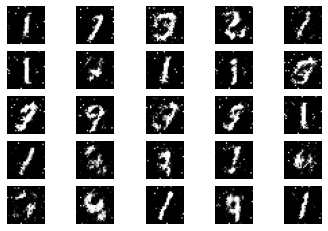

In [11]:
# Device placement
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

gen_model.to('cuda:0')
disc_model.to('cuda:0')
# The part till here is updated. As we have to set them to the same device.

# Training Loop
img_list = []
G_losses = []
D_losses = []

sample_interval = 25

print("Starting Training")

# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(mnist_train_loader, 0):
        for iter_inner in range(0, n_iters_inner):
            ############################
            ### Train discriminator
            ############################
            ## Train with true data batch
            disc_model.zero_grad()
            # create true data and labels 
            true_imgs = data[0][np.random.randint(data[0].shape[0], size=sample_interval), :, :, :].to(device)
            true_labels = torch.full((sample_interval,), 1).unsqueeze(1).to(torch.float32).to(device)
            # put true data through discriminator
            d_output_true = disc_model(true_imgs)
            # bce loss on true data
            d_loss_true = bce_criterion(d_output_true, true_labels)
            # backpropagation for discriminator, true loss
            d_loss_true.backward()
            disc_true_value = d_output_true.mean().item()

            ## Train with fake data batch
            # create fake data and labels
            # generate batch of random latent vectors
            z_latent_noise = torch.randn(size=(sample_interval, z_dim)).to(device)
            # Generate batch of fake images
            fake_imgs = gen_model(z_latent_noise)
            fake_labels = torch.full((sample_interval,), 0).unsqueeze(1).to(torch.float32).to(device)
            # put fake data through discriminator
            disc_output_fake = disc_model(fake_imgs)
            # bce loss on fake data
            disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
            # backpropagation for discriminator, fake loss
            disc_loss_fake.backward()
            disc_fake_value = disc_output_fake.mean().item()
            # Update discriminator
            optimizer_disc.step()

            d_loss_total = d_loss_true + disc_loss_fake

        ############################
        ### Train generator
        ############################
        gen_model.zero_grad()
        # We have updated the discriminator, so we need to update the output of the discriminator
        disc_gen_output_fake = disc_model(gen_model(z_latent_noise))
        # Generator loss, using the custom loss
        g_loss = loss_fn_gen(disc_gen_output_fake)
        # backpropagation for generator
        g_loss.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, n_epochs, i, len(mnist_train_loader), d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss_total.item())

    if epoch % sample_interval == 0:
        sample_images(gen_model, z_dim, rand_seed=30)

# end samples
sample_images(gen_model, z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

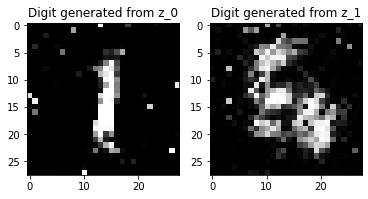

In [12]:
# Set random seed
torch.manual_seed(26)

# Generate two random points in latent space
z_0 = torch.randn((1, z_dim)).to(device)
x_0 = gen_model(z_0)

# Generate images from the latent vectors
z_1 = torch.randn((1, z_dim)).to(device)
x_1 = gen_model(z_1)

# Display the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_0.squeeze().cpu().detach().numpy(), cmap='gray')
ax[0].set_title('Digit generated from z_0')
ax[1].imshow(x_1.squeeze().cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Digit generated from z_1')
plt.show()


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

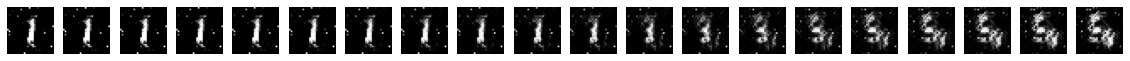

In [13]:
n_interpolation = 20

def generate_interpolation(gen_model, z_0, z_1, n_interpolation):
    weights = torch.linspace(0, 1, n_interpolation+2)[1:-1].unsqueeze(-1).to(z_0.device)
    z_interpolations = torch.lerp(z_0, z_1, weights)
    
    generated_images = gen_model(z_interpolations)
    
    interpolation_list = [(img, z) for img, z in zip(generated_images, z_interpolations)]
    
    return interpolation_list

interpolation_list = generate_interpolation(gen_model, z_0, z_1, n_interpolation)

# Display the results
fig, axs = plt.subplots(1, n_interpolation, figsize=(20, 20))
for i in range(n_interpolation):
    axs[i].imshow(interpolation_list[i][0].detach().cpu().squeeze().numpy(), cmap='gray')
    axs[i].axis('off')
plt.show()


In [14]:
# display results

# fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
# for i in range(n_interpolation):
#   #black and white images
#   axs[i].imshow( ... , cmap='gray')  # FILL IN HERE
#   axs[i].axis('off')
# plt.show()

What do you think of the quality of the output images ?

__Answer__

The quality of the output images looks good. We can see a smooth transition from one digit to another through the generated images, except for two or three examples where they look like 3.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [15]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = nn.Sequential(
    nn.Conv2d(in_channels = n_h_0, out_channels = n_h_1, kernel_size = kernel_size, stride = (2,2)),
    nn.ReLU(),
    nn.Conv2d(in_channels = n_h_1, out_channels = n_h_2, kernel_size = kernel_size, stride = (2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = pool_size, stride=(2,2)),
    nn.Flatten(),
    nn.Linear(288,nb_classes)
    )

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [16]:
# training the classifier
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))


Epoch:0 Train Loss:0.0275 Accuracy:0.6000
Epoch:1 Train Loss:0.0150 Accuracy:0.8250
Epoch:2 Train Loss:0.0097 Accuracy:0.8750
Epoch:3 Train Loss:0.0075 Accuracy:0.9000
Epoch:4 Train Loss:0.0025 Accuracy:0.9500
Epoch:5 Train Loss:0.0010 Accuracy:1.0000
Epoch:6 Train Loss:0.0019 Accuracy:1.0000
Epoch:7 Train Loss:0.0013 Accuracy:0.9750
Epoch:8 Train Loss:0.0049 Accuracy:0.9500
Epoch:9 Train Loss:0.0037 Accuracy:0.9500
Epoch:10 Train Loss:0.0004 Accuracy:1.0000
Epoch:11 Train Loss:0.0002 Accuracy:1.0000
Epoch:12 Train Loss:0.0002 Accuracy:1.0000
Epoch:13 Train Loss:0.0002 Accuracy:1.0000
Epoch:14 Train Loss:0.0001 Accuracy:1.0000
Epoch:15 Train Loss:0.0001 Accuracy:1.0000
Epoch:16 Train Loss:0.0001 Accuracy:1.0000
Epoch:17 Train Loss:0.0001 Accuracy:1.0000
Epoch:18 Train Loss:0.0001 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [17]:
def predict_mnist_class(imgs_in,classification_model):
  
  # Move tensors to the same device as the model (CPU or GPU)
  device = next(classification_model.parameters()).device
  imgs_in = imgs_in.to(device)

  # Reshape the input tensor to have the correct shape
  imgs_in = imgs_in.view(-1, 1, 28, 28)
  output_classes = mnist_classification_model(imgs_in).max(1)[1]
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

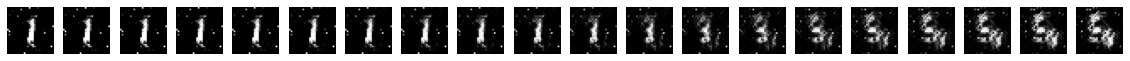

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 5, 5, 5, 5, 5])


In [18]:
n_interpolation = 20

interpolation_list = generate_interpolation(gen_model, z_0, z_1, n_interpolation)

fig, axs = plt.subplots(1, n_interpolation, figsize=(20, 20))
for i in range(n_interpolation):
    axs[i].imshow(interpolation_list[i][0].detach().cpu().squeeze().numpy(), cmap='gray')
    axs[i].axis('off')
plt.show()

z_tensors = torch.stack([z[0] for z in interpolation_list])
z_classes = predict_mnist_class(z_tensors, mnist_classification_model)

print(z_classes)

__Answer__

Interpolation traverses the '3' region instead of '5' when it comes from '1' region, as expected intuition. 

### 7.2/ Evaluation of navigation 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [19]:
def predict_mnist_confidence(imgs_in, classification_model):
    # Move the input tensor to the same device as the model's parameters
    device = next(classification_model.parameters()).device
    imgs_in = imgs_in.to(device)

    # Reshape the input tensor to have the correct shape
    imgs_in = imgs_in.view(-1, 1, 28, 28)

    # Compute the output of the model
    output = classification_model(imgs_in)

    # Compute the probability of the most likely class for each input
    probs, _ = torch.max(torch.softmax(output, dim=1), dim=1)
    output_classes = probs.detach().cpu().numpy()
    return (output_classes)



Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [20]:
# Reshape the generated images
generated_images = torch.stack([z[0] for z in interpolation_list])
generated_images = generated_images.view(-1, 1, 28, 28)

# Get the predicted class confidences
z_confidence = predict_mnist_confidence(generated_images, mnist_classification_model)

print(z_confidence)


[0.99954236 0.99963987 0.99971133 0.9997614  0.9998104  0.9998461
 0.99987495 0.99989223 0.99988663 0.9998172  0.99958414 0.9963081
 0.8912975  0.47795755 0.61354613 0.83318853 0.9745962  0.9910177
 0.9933067  0.990139  ]


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

The confidence of the classification network decreases gradually during the interpolation process. The confidence is very high for the starting and ending points, but gradually decreases for the intermediate points or the points in between. Additionally, there are a few points in the middle where the confidence is lower than the rest of the points. This suggests that the latent space contains some regions where the classification network is not very confident, i.e., the classification network is not sure which class an image in that region corresponds to.

One possible explanation for this could be that the latent space contains regions where the encoded features do not match the learned features in the classification network. Another possibility is that the latent space contains regions that are ambiguous and can correspond to different classes. Finally, it is possible that the resolution of the latent space is not sufficient to capture all the features of the MNIST dataset, leading to some regions being less well-defined.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [21]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Files already downloaded and verified


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [22]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 